## Advanced Lane Lining
#### Steps to perform

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 0) Import the libraries

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2

import glob
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

print('Output: all listed libraries are imported')

Output: all listed libraries are imported


### 1) camera calibration and distortion coefficient

In [2]:
# set the 3D and 2D points in real and image plane
def calibCamera():
    images = glob.glob('camera_cal/calibration*.jpg') # access all calibration images   
    # set the chessboard size
    nx = 9
    ny = 6

    # Store the 3D and 2D points
    objpoints = [] # 3D points in the real world plane
    imgpoints = [] # 2D points in the image plane

    # prepare the object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

    for image in images:
        img = mpimg.imread(image) # read the image
        
     # Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). 
     # Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert the image to gray color space

        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) # find the chessboard corners 

        if ret:
            imgpoints.append(corners) # fill the image corner points
            objpoints.append(objp) # fill the object points in real world plane

            # draw the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #plt.figure()
            #plt.imshow(img)
    #calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    return mtx, dist

def undistImage(img, mtx, dist):
    #undistort the given image
    undistImg = cv2.undistort(img, mtx, dist, None, mtx)
    return undistImg

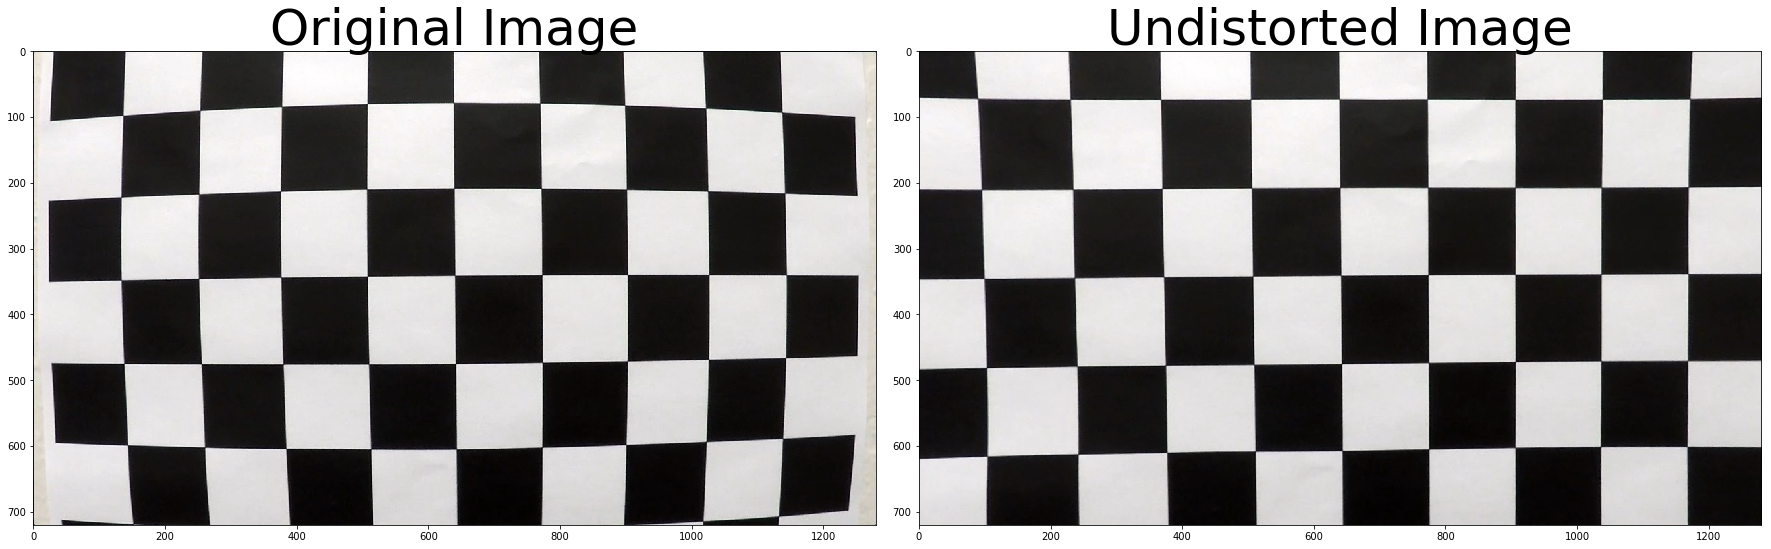

In [3]:
# find distortion coeefficent
img = mpimg.imread('camera_cal/calibration1.jpg') # example image
mtx, dist = calibCamera()
undistImg = undistImage(img, mtx, dist)

# show the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistImg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave('output_images/undistorted_calibration1.jpg', undistImg)

### 2) Apply a distortion correction to raw images

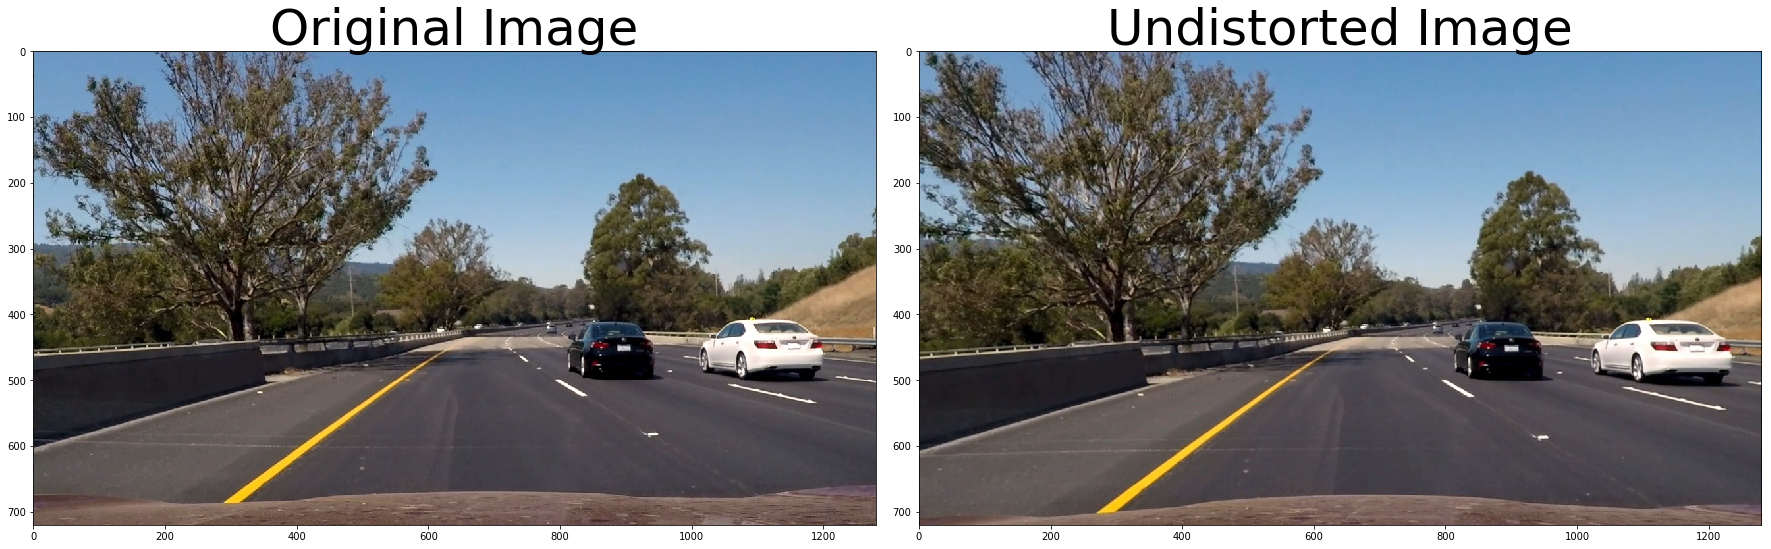

In [4]:
img = mpimg.imread('test_images/test6.jpg') # example road image dsitortion correction
undistImg = undistImage(img, mtx, dist)

# show the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistImg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave('output_images/undistorted_roadImage.jpg', undistImg)

### 3) Use color transforms, gradients, etc., to create a thresholded binary image

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold  
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    if orient == 'x':
        gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_gradx = np.sqrt(np.power(gradx,2))
        scaled_grad= np.uint8(255*abs_gradx/np.max(abs_gradx))
        grad_binary = np.zeros_like(scaled_grad)
        grad_binary[(scaled_grad >= thresh[0]) & (scaled_grad <= thresh[1])] = 1
    elif orient == 'y':    
        grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_grady = np.sqrt(np.power(grady,2))
        scaled_grad= np.uint8(255*abs_grady/np.max(abs_grady))
        grad_binary = np.zeros_like(scaled_grad)
        grad_binary[(scaled_grad >= thresh[0]) & (scaled_grad <= thresh[1])] = 1   
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_grad = np.sqrt(np.power(gradx,2)+np.power(grady,2))
    # Create a binary mask where direction thresholds are met
    scaled_sobel = np.uint8(255*abs_grad/np.max(abs_grad))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1  
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_gradx = np.sqrt(np.power(gradx,2))
    abs_grady = np.sqrt(np.power(grady,2))
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_grady,abs_gradx)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return dir_binary


Text(0.5,1,'combined')

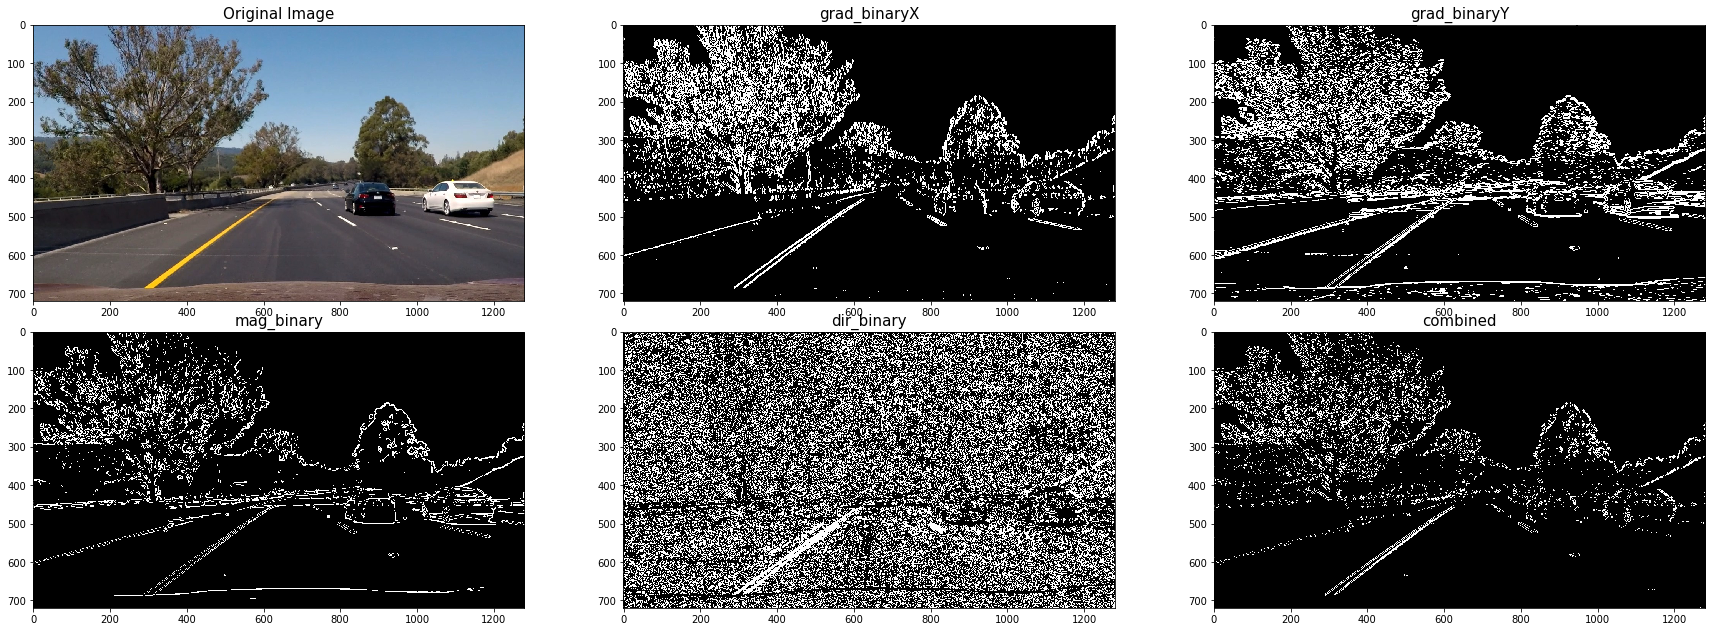

In [6]:
# Test tresholding methods
kernel_size = 9
grad_binaryX = abs_sobel_thresh(img, orient='x', sobel_kernel=kernel_size,  thresh=(20, 100))
grad_binaryY = abs_sobel_thresh(img, orient='y', sobel_kernel=kernel_size, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=kernel_size, thresh=(50, 100))
dir_binary = dir_thresh(img, sobel_kernel=kernel_size, thresh=(0.7, 1.3))

combined_t = np.zeros_like(dir_binary)
combined_t[((grad_binaryX == 1) & (grad_binaryY == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, axs = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
axs[0,0].imshow(img)
axs[0,0].set_title('Original Image', fontsize=15)
axs[0,1].imshow(grad_binaryX, cmap='gray')
axs[0,1].set_title('grad_binaryX', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0)
plt.imsave('output_images/grad_binaryX_roadImage.jpg', grad_binaryX)
axs[0,2].imshow(grad_binaryY, cmap='gray')
axs[0,2].set_title('grad_binaryY', fontsize=15)
plt.imsave('output_images/grad_binaryY_roadImage.jpg', grad_binaryY)
axs[1,0].imshow(mag_binary, cmap='gray')
axs[1,0].set_title('mag_binary', fontsize=15)
plt.imsave('output_images/grad_binaryY_roadImage.jpg', mag_binary)
axs[1,1].imshow(dir_binary, cmap='gray')
axs[1,1].set_title('dir_binary', fontsize=15)
plt.imsave('output_images/grad_binaryY_roadImage.jpg', dir_binary)
axs[1,2].imshow(combined_t, cmap='gray')
axs[1,2].set_title('combined', fontsize=15)


### 3.1) HLS color tresholding
- Reason: the above performed tests are not enough 
- H: Hue (color) ,  L: Lightening (brightness), S: Saturation(changes in color)
- H could be helpful for the yellow line
- L could be helpful for the white line
- S will be helpful for better edge detection

In [7]:
def hls_thresh(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    thresh_h = (10,60)
    thresh_l = (200,255)
    thresh_s = (90,255)
    h_binary = np.zeros_like(h)
    h_binary[(h >= thresh_h[0]) & (h <= thresh_h[1])] = 1
    l_binary = np.zeros_like(l)
    l_binary[(l >= thresh_l[0]) & (l <= thresh_h[1])] = 1
    s_binary = np.zeros_like(s)
    s_binary[(s >= thresh_s[0]) & (s <= thresh_s[1])] = 1
    
    combined_hs = np.zeros_like(h)
    #combined_hs[((h_binary == 1) | (s_binary == 1)) | (l_binary==1) ] = 1
    combined_hs[((s_binary == 1)) | (l_binary==1) ] = 1
    #combined_hs[((h_binary == 1) | (s_binary == 1))] = 1
    #combined_hs[((s_binary == 1))] = 1
    return combined_hs

# hls_binary = hls_thresh(img)
# combined = np.zeros_like(dir_binary)
# # #combined[((grad_binaryX == 1) & (grad_binaryY == 1)) | ((mag_binary == 1) & (dir_binary == 1))| (hls_binary == 1) ] = 1
# combined[(grad_binaryX == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1) ] = 1

# plt.imshow(combined, cmap='gray')
# plt.imsave('output_images/hlsthresh_roadImage.jpg', combined)

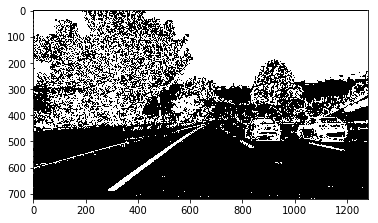

In [8]:
def combinedThresh(img):
    kernel_size = 9
    grad_binaryX = abs_sobel_thresh(img, orient='x', sobel_kernel=kernel_size,  thresh=(20, 100))
    grad_binaryY = abs_sobel_thresh(img, orient='y', sobel_kernel=kernel_size, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=kernel_size, thresh=(50, 100))
    dir_binary = dir_thresh(img, sobel_kernel=kernel_size, thresh=(0.7, 1.3))
    hls_binary = hls_thresh(img)
    
    combined = np.zeros_like(dir_binary)
    combined[(grad_binaryX == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1) ] = 1
    return combined

combined = combinedThresh(img)
plt.imshow(combined, cmap='gray')
plt.imsave('output_images/hlsthresh_roadImage.jpg', combined)

### 4) Apply a perspective transform to rectify binary image ("birds-eye view")

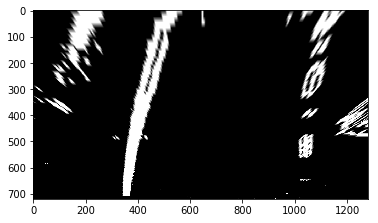

In [9]:
def perspectiveTransform(img):

    src = np.float32([
        [700, 450], # top right
        [1100, img.shape[0] ], # bottom right
        [180, img.shape[0]], # bottom left
        [600, 450]]) # top left   
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([
        [980,0],             # top right
        [980,img.shape[0]],  # bottom right
        [300,img.shape[0]],  # bottom left
        [300,0]])            # top left  
    '''
    src = np.float32([
        [680, 460],            # top right
        [1050, img.shape[0] ], # bottom right
        [200, img.shape[0]],   # bottom left
        [550, 460]])           # top left   
    #  define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([
        [900,0],             # top right
        [980,img.shape[0]],  # bottom right
        [440,img.shape[0]],  # bottom left
        [410,0]])            # top left  
    '''
    # get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst) 
    # get inverse M, the transform matrix, to transform the perspective image back to original image
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # warp an image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv

binary_warped, M, M_inv = perspectiveTransform(combined)

plt.imshow(binary_warped, cmap='gray')
plt.imsave('output_images/persTrans_roadImage.jpg', binary_warped)

# histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# plt.plot(histogram)

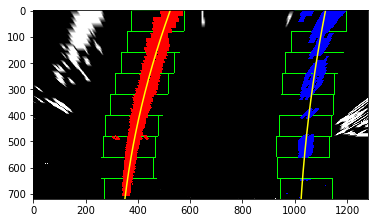

In [10]:
def find_lane_pixels(binary_warped):
     # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
   
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
   
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
          
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
           
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(leftx, lefty, rightx, righty):   
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def drawImage(binary_warped, left_fit, right_fit, out_img):  
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img.astype('uint8'))
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return out_img

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
out_img = drawImage(binary_warped, left_fit, right_fit, out_img)
plt.imsave('output_images/lanesWindow_roadImage.jpg', out_img.astype('uint8'))

### 5) Determine the curvature of the lane and vehicle position with respect to center

In [20]:
def cal_Curvature_VehPos(binary_warped):
    '''
    Calculates the curvature of polynomial functions and vehicle position with respect to center in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find lane pixels and fit in polynom to find polynom's coeefficents
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)  
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)

    # Fit new polynomials to x,y in world space    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty    
    
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warped.shape[0]
    
    # Implement the calculation of R_curve on the left and on the right (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad + right_curverad)//2
    
     # Calculate left and right line positions at the bottom of the image
    left_line_x_pos = (left_fit[0]*(y_eval**2))+(left_fit[1]*y_eval)+left_fit[2]
    right_line_x_pos = (right_fit[0]*(y_eval**2))+(right_fit[1]*y_eval)+right_fit[2]

    mid_lanes_x_pos = (left_line_x_pos + right_line_x_pos)//2 # calculate the average curvature
        
    x_mid = binary_warped.shape[1]//2
        
    vehPos_offset = (mid_lanes_x_pos- x_mid) * xm_per_pix # find the vehicle position on the real world
    
    return ploty, left_fitx, right_fitx, left_curverad, right_curverad, curvature, veh_pos


# # Calculate the radius of curvature in meters for both lane lines
ploty, left_fitx, right_fitx, left_curverad, right_curverad, curvature, vehPos_offset= cal_Curvature_VehPos(binary_warped)
print('Left curvature:', left_curverad, 'm')
print('Right curvature:', right_curverad, 'm')
print('Curvature: ',curvature, 'm')
print('Vehicle Position: ', vehPos_offset)

Left curvature: 988.667623267 m
Right curvature: 1794.2419502 m
Curvature:  1391.0 m
Vehicle Position:  0.248428571429


### 6) Warp the detected lane boundaries back onto the original image and create a pipeline

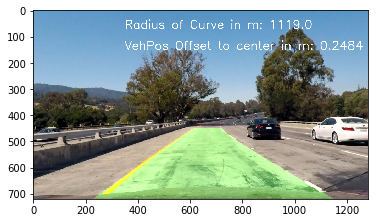

In [21]:
img = mpimg.imread('test_images/test1.jpg') # example image : test2, test3, test4, test5, test6 are also tested

def pipeline(img):
    mtx, dist = calibCamera()
    undistImg = undistImage(img, mtx, dist)
    
    combined = combinedThresh(img)
    
    binary_warped, M, M_inv = perspectiveTransform(combined)
    ploty, left_fitx, right_fitx, left_curverad, right_curverad, curvature, veh_pos = cal_Curvature_VehPos(binary_warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistImg, 1, newwarp, 0.3, 0)
    cv2.putText(result,'Radius of Curve in m: '+str(curvature)[:6],(350,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'VehPos Offset to center in m: '+str(veh_pos)[:6],(350,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    return result

result = pipeline(img )
plt.imshow(result)
plt.imsave('output_images/result_roadImage.jpg', out_img.astype('uint8'))

### 7) Video Clip

In [16]:
class Line():
    def __init__(self):
        # if it is first Run
        self.firstRun = True # to calculate the initial line pixels only once   
        self.cameraCal = True # to calibrate camera only once 
        self.right_fit=[np.array([False])] # store preivous right line pixels
        self.left_fit=[np.array([False])]  # store preivous left line pixels
        self.mtx = [np.array([False])]  # store the camera calibration matrix after the first run to use in next runs
        self.dist = [np.array([False])] # store the distortion coeeficient matrix after the first run to use in next runs
    @staticmethod
    def vidPipeline(img):
        if Line.cameraCal == True:
            print('First run/frame: Camera Calibration Done ')
            mtx, dist = calibCamera() #done only once
            Line.mtx = mtx 
            Line.dist = dist
            Line.cameraCal = False 
        else:
            mtx = Line.mtx
            dist = Line.dist
    
        undistImg = undistImage(img, mtx, dist) # undistort the image

        combined = combinedThresh(img) # calculate the combined thresholding : hls, sobel-,magnitude,direcetional

        binary_warped, M, M_inv = perspectiveTransform(combined) # genrater wapred image, and calculate transfromation matrix
        
        if Line.firstRun == True: 
            print('First run/frame: Starting Lane Pixels Calculated ')
            leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
            left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
            Line.right_fit = right_fit
            Line.left_fit = left_fit
            Line.firstRun = False
        else:
            
            left_fit=Line.left_fit # take the previos lane pixel to continue
            right_fit=Line.right_fit

            margin = 100
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                            left_fit[1]*nonzeroy + left_fit[2] + margin))).nonzero()[0]
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                            right_fit[1]*nonzeroy + right_fit[2] + margin))).nonzero()[0]

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]      

            # Fit a second order polynomial to pixel positions in each lane line
            left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
                        
            Line.right_fit = right_fit # store the new polynaomial pixel position for the next frame
            Line.left_fit = left_fit

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty    

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Measure the curvature in meter
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = binary_warped.shape[0]

        # Implement the calculation of R_curve on the left and on the right (radius of curvature)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        curvature = (left_curverad + right_curverad)//2

        # Calculate left and right line positions at the bottom of the image
        left_line_x_pos = (left_fit[0]*(y_eval**2))+(left_fit[1]*y_eval)+left_fit[2]
        right_line_x_pos = (right_fit[0]*(y_eval**2))+(right_fit[1]*y_eval)+right_fit[2]

        mid_lanes_x_pos = (left_line_x_pos + right_line_x_pos)//2 # calculate the average curvature
        
        x_mid = binary_warped.shape[1]//2
        
        vehPos_offset = (mid_lanes_x_pos- x_mid) * xm_per_pix # find the vehicle position on the real world

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistImg, 1, newwarp, 0.3, 0)
        cv2.putText(result,'Radius of Curve in m: '+str(curvature)[:6],(350,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255),2,cv2.LINE_AA)
        cv2.putText(result,'VehPos Offset to center in m: '+str(vehPos_offset)[:6],(350,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
        return result

In [17]:
Line = Line()
video_output = 'output_videos/output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(Line.vidPipeline)
%time video_clip.write_videofile(video_output, audio=False)

First run/frame: Camera Calibration Done 
First run/frame: Starting Lane Pixels Calculated 
[MoviePy] >>>> Building video output_videos/output_project_video.mp4
[MoviePy] Writing video output_videos/output_project_video.mp4


100%|█████████▉| 1260/1261 [08:01<00:00,  2.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_project_video.mp4 

CPU times: user 5min 53s, sys: 3.74 s, total: 5min 57s
Wall time: 8min 4s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))